Number of top authors: 5

Final corpus authors: ['carefree-lark', 'intense-toad', 'springy-hare', 'sudsy-jellyfish', 'vivid-rhinoceros']
Feature matrix shape: (69, 8662)


2025-10-18 12:14:42.210 | INFO     | wa_analyzer.model:fit:35 - Vectorized text into shape (69, 8662)
2025-10-18 12:14:42.270 | INFO     | wa_analyzer.model:reduce_dims:45 - Using t-SNE


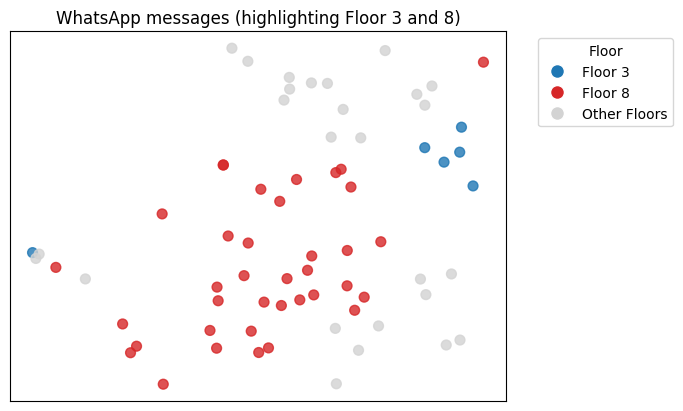

In [1]:
# %%
import seaborn as sns
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
import re
from sklearn.feature_extraction.text import CountVectorizer
from wa_analyzer.model import TextClustering

# Initialize clustering model
clustering = TextClustering()

# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# --- Load configuration and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

df = pd.read_parquet(datafile)

# %%
# --- Count messages per author ---
top_authors = df['author'].value_counts().head(5).index # default = 20 of 5
df_top = df[df['author'].isin(top_authors)].copy()
authors = list(np.unique(df_top.author))
print(f"Number of top authors: {len(authors)}")

# %%
# --- Helper to remove URLs ---
def remove_url(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

# %%
# --- Create corpus of text chunks per author ---
# sweet spot n = 2000/2500, min_parts = 4/5, of n = 3000, min_parts = 4
n = 3000       # chunk size
min_parts = 2  # minimum chunks

corpus = {}
for author in authors:
    subset = df_top[df_top.author == author].reset_index()
    longseq = " ".join(subset.message)
    parts = [longseq[i:i+n] for i in range(0, len(longseq), n)]
    parts = [remove_url(chunk) for chunk in parts]
    parts = [re.sub(" +", " ", chunk) for chunk in parts]
    if len(parts) > min_parts:
        corpus[author] = parts

print(f"\nFinal corpus authors: {list(corpus.keys())}")

# %%
# --- Feature extraction ---
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
parts = [part for text in corpus.values() for part in text]
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())
print(f"Feature matrix shape: {X.shape}")

# %%
# --- Load author metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
)

# %%
# --- Prepare labels for clustering ---
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]
floor_map = author_info_df.set_index("author")["Floor_nr"].to_dict()
highlight_floors = [3, 8]

# Encode labels and assign colors
labels_for_plot = []
colors = []
for author in wa_labels:
    floor = floor_map.get(author, None)
    if floor == 3:
        labels_for_plot.append("Floor 3")
        colors.append("tab:blue")
    elif floor == 8:
        labels_for_plot.append("Floor 8")
        colors.append("tab:red")
    else:
        labels_for_plot.append("Other Floors")
        colors.append("lightgrey")

# %%
# --- Run clustering ---
# Note: TextClustering does not accept colors, so we just use it for positions
clustering(
    text=[part for text in corpus.values() for part in text],
    k=500,
    labels=None,  # We'll handle coloring manually
    batch=False,
    method="tSNE"
    #  method="PCA"
)

# %%
# --- Overlay points with manual colors ---
# Extract the scatter points from the last clustering plot
sc = plt.gca().collections[0]
offsets = sc.get_offsets()

plt.clf()  # Clear previous plot
plt.scatter(offsets[:, 0], offsets[:, 1], c=colors, s=50, alpha=0.8)

# Legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:blue', markersize=10, label='Floor 3'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:red', markersize=10, label='Floor 8'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgrey', markersize=10, label='Other Floors')
]
plt.legend(handles=legend_elements, title="Floor", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.xticks([])
plt.yticks([])
plt.title("WhatsApp messages (highlighting Floor 3 and 8)")

plt.show()


In [20]:
# %%
import seaborn as sns
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
import re
from sklearn.feature_extraction.text import CountVectorizer
from wa_analyzer.model import TextClustering

# Initialize clustering model
clustering = TextClustering()

# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# --- Load configuration and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

df = pd.read_parquet(datafile)

# %%
# --- Filter for the word 'camera' in the 'message' column ---
camera_df = df[df['message'].str.contains('camera', case=False, na=False)]
print(f"Number of messages containing 'camera': {len(camera_df)}")

# If there are no messages containing 'camera', exit the script early
if camera_df.empty:
    print("No messages containing 'camera' found. Exiting.")
    exit()

# %%
# --- Count messages per author ---
top_authors = camera_df['author'].value_counts().head(40).index  # Filtered by camera messages
df_top = camera_df[camera_df['author'].isin(top_authors)].copy()
authors = list(np.unique(df_top.author))
print(f"Number of top authors: {len(authors)}")

# %%
# --- Helper to remove URLs ---
def remove_url(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

# %%
# --- Create corpus of text chunks per author ---
n = 1000       # chunk size
min_parts = 2  # minimum chunks

corpus = {}
for author in authors:
    subset = df_top[df_top.author == author].reset_index()
    longseq = " ".join(subset.message)
    parts = [longseq[i:i+n] for i in range(0, len(longseq), n)]
    parts = [remove_url(chunk) for chunk in parts]
    parts = [re.sub(" +", " ", chunk) for chunk in parts]
    if len(parts) > min_parts:
        corpus[author] = parts

print(f"\nFinal corpus authors: {list(corpus.keys())}")

# %%
# --- Feature extraction ---
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
parts = [part for text in corpus.values() for part in text]
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())
print(f"Feature matrix shape: {X.shape}")

# %%
# --- Load author metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
)

# %%
# --- Prepare labels for clustering based on age ---
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]
age_map = author_info_df.set_index("author")["Older_then_50"].to_dict()

# Encode labels and assign colors
colors = []
for author in wa_labels:
    is_older = age_map.get(author, None)
    
    if is_older:
        colors.append("tab:orange")  # Color for older
    else:
        colors.append("tab:green")    # Color for younger

# %%
# --- Run clustering ---
clustering(
    text=[part for text in corpus.values() for part in text],
    k=500,
    labels=None,  # We'll handle coloring manually
    batch=False,
    method="tSNE"  # or "PCA"
)

# %%
# --- Overlay points with manual colors ---
# Extract the scatter points from the last clustering plot
sc = plt.gca().collections[0]
offsets = sc.get_offsets()

plt.clf()  # Clear previous plot
plt.scatter(offsets[:, 0], offsets[:, 1], c=colors, s=50, alpha=0.8)

# Legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:orange', markersize=10, label='Older than 50'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:green', markersize=10, label='Younger than 50')
]
plt.legend(handles=legend_elements, title="Age", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.xticks([])
plt.yticks([])
plt.title("WhatsApp messages (highlighting Age) with 'camera'")

plt.show()

2025-10-18 13:28:03.709 | INFO     | wa_analyzer.model:fit:35 - Vectorized text into shape (27, 3084)
2025-10-18 13:28:03.714 | INFO     | wa_analyzer.model:reduce_dims:45 - Using t-SNE


Number of messages containing 'camera': 118
Number of top authors: 26

Final corpus authors: ['carefree-lark', 'eye-catching-hare', 'intense-toad', 'springy-hare', 'vivid-rhinoceros']
Feature matrix shape: (27, 3084)


ValueError: perplexity must be less than n_samples

Number of top authors: 40

Final corpus authors: ['cackling-eland', 'carefree-lark', 'cheerful-mule', 'eye-catching-hare', 'flexible-platypus', 'happy-beaver', 'intense-toad', 'limber-ostrich', 'radiant-coyote', 'silky-lapwing', 'snorting-ibex', 'springy-hare', 'sudsy-eland', 'sudsy-jellyfish', 'vivid-rhinoceros', 'zany-trout']
Feature matrix shape: (118, 11016)


2025-10-18 12:35:10.396 | INFO     | wa_analyzer.model:fit:35 - Vectorized text into shape (118, 11016)
2025-10-18 12:35:10.656 | INFO     | wa_analyzer.model:reduce_dims:45 - Using t-SNE


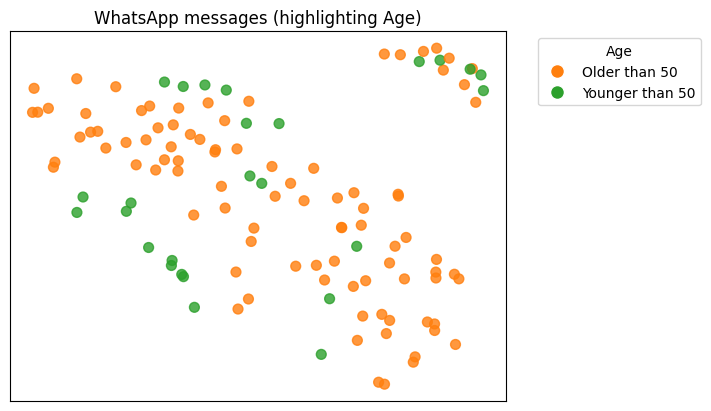

In [7]:
# %%
import seaborn as sns
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
import re
from sklearn.feature_extraction.text import CountVectorizer
from wa_analyzer.model import TextClustering

# Initialize clustering model
clustering = TextClustering()

# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# --- Load configuration and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

df = pd.read_parquet(datafile)

# %%
# --- Count messages per author ---
top_authors = df['author'].value_counts().head(40).index  # default = 20 of 5
df_top = df[df['author'].isin(top_authors)].copy()
authors = list(np.unique(df_top.author))
print(f"Number of top authors: {len(authors)}")

# %%
# --- Helper to remove URLs ---
def remove_url(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

# %%
# --- Create corpus of text chunks per author ---
n = 3000       # chunk size
min_parts = 2  # minimum chunks

corpus = {}
for author in authors:
    subset = df_top[df_top.author == author].reset_index()
    longseq = " ".join(subset.message)
    parts = [longseq[i:i+n] for i in range(0, len(longseq), n)]
    parts = [remove_url(chunk) for chunk in parts]
    parts = [re.sub(" +", " ", chunk) for chunk in parts]
    if len(parts) > min_parts:
        corpus[author] = parts

print(f"\nFinal corpus authors: {list(corpus.keys())}")

# %%
# --- Feature extraction ---
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
parts = [part for text in corpus.values() for part in text]
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())
print(f"Feature matrix shape: {X.shape}")

# %%
# --- Load author metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
)

# %%
# --- Prepare labels for clustering based on age ---
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]
age_map = author_info_df.set_index("author")["Older_then_50"].to_dict()

# Encode labels and assign colors
colors = []
for author in wa_labels:
    is_older = age_map.get(author, None)
    
    if is_older:
        colors.append("tab:orange")  # Color for older
    else:
        colors.append("tab:green")    # Color for younger

# %%
# --- Run clustering ---
clustering(
    text=[part for text in corpus.values() for part in text],
    k=500,
    labels=None,  # We'll handle coloring manually
    batch=False,
    method="tSNE" #"PCA"
)

# %%
# --- Overlay points with manual colors ---
# Extract the scatter points from the last clustering plot
sc = plt.gca().collections[0]
offsets = sc.get_offsets()

plt.clf()  # Clear previous plot
plt.scatter(offsets[:, 0], offsets[:, 1], c=colors, s=50, alpha=0.8)

# Legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:orange', markersize=10, label='Older than 50'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:green', markersize=10, label='Younger than 50')
]
plt.legend(handles=legend_elements, title="Age", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.xticks([])
plt.yticks([])
plt.title("WhatsApp messages (highlighting Age)")

plt.show()

Number of top authors: 40

Final corpus authors: ['cackling-eland', 'carefree-lark', 'cheerful-mule', 'eye-catching-hare', 'flexible-platypus', 'happy-beaver', 'intense-toad', 'limber-ostrich', 'radiant-coyote', 'silky-lapwing', 'snorting-ibex', 'springy-hare', 'sudsy-eland', 'sudsy-jellyfish', 'vivid-rhinoceros', 'zany-trout']
Feature matrix shape: (118, 11016)


2025-10-18 12:39:59.447 | INFO     | wa_analyzer.model:fit:35 - Vectorized text into shape (118, 11016)
2025-10-18 12:39:59.642 | INFO     | wa_analyzer.model:reduce_dims:45 - Using t-SNE


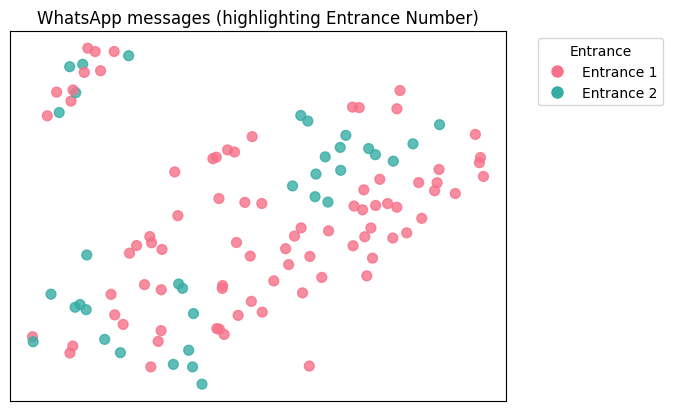

In [9]:
# %%
import seaborn as sns
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
import re
from sklearn.feature_extraction.text import CountVectorizer
from wa_analyzer.model import TextClustering

# Initialize clustering model
clustering = TextClustering()

# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# --- Load configuration and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

df = pd.read_parquet(datafile)

# %%
# --- Count messages per author ---
top_authors = df['author'].value_counts().head(40).index  # Increase to 40 for more variety
df_top = df[df['author'].isin(top_authors)].copy()
authors = list(np.unique(df_top.author))
print(f"Number of top authors: {len(authors)}")

# %%
# --- Helper to remove URLs ---
def remove_url(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

# %%
# --- Create corpus of text chunks per author ---
n = 3000       # chunk size
min_parts = 2  # minimum chunks

corpus = {}
for author in authors:
    subset = df_top[df_top.author == author].reset_index()
    longseq = " ".join(subset.message)
    parts = [longseq[i:i+n] for i in range(0, len(longseq), n)]
    parts = [remove_url(chunk) for chunk in parts]
    parts = [re.sub(" +", " ", chunk) for chunk in parts]
    if len(parts) > min_parts:
        corpus[author] = parts

print(f"\nFinal corpus authors: {list(corpus.keys())}")

# %%
# --- Feature extraction ---
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
parts = [part for text in corpus.values() for part in text]
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())
print(f"Feature matrix shape: {X.shape}")

# %%
# --- Load author metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
)

# %%
# --- Prepare labels for clustering based on entrance_nr ---
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]
entrance_map = author_info_df.set_index("author")["Entrance_nr"].to_dict()

# Encode labels and assign colors
colors = []
unique_entrances = list(set(entrance_map.values()))
entrance_colors = sns.color_palette("husl", len(unique_entrances))  # Generate distinct colors

for author in wa_labels:
    entrance = entrance_map.get(author, None)
    if entrance is not None:
        entrance_index = unique_entrances.index(entrance)
        colors.append(entrance_colors[entrance_index])  # Assign color based on entrance
    else:
        colors.append("lightgrey")  # Default color for unknown entrances

# %%
# --- Run clustering ---
clustering(
    text=[part for text in corpus.values() for part in text],
    k=500,
    labels=None,  # We'll handle coloring manually
    batch=False,
    method="tSNE"
)

# %%
# --- Overlay points with manual colors ---
# Extract the scatter points from the last clustering plot
sc = plt.gca().collections[0]
offsets = sc.get_offsets()

plt.clf()  # Clear previous plot
plt.scatter(offsets[:, 0], offsets[:, 1], c=colors, s=50, alpha=0.8)

# Legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Entrance {entrance}')
    for entrance, color in zip(unique_entrances, entrance_colors)
]
plt.legend(handles=legend_elements, title="Entrance", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.xticks([])
plt.yticks([])
plt.title("WhatsApp messages (highlighting Entrance Number)")

plt.show()

Number of top authors: 40

Final corpus authors: ['cackling-eland', 'carefree-lark', 'cheerful-mule', 'eye-catching-hare', 'flexible-platypus', 'happy-beaver', 'intense-toad', 'limber-ostrich', 'radiant-coyote', 'silky-lapwing', 'snorting-ibex', 'springy-hare', 'sudsy-eland', 'sudsy-jellyfish', 'vivid-rhinoceros', 'zany-trout']
Feature matrix shape: (118, 11016)


2025-10-18 12:52:32.430 | INFO     | wa_analyzer.model:fit:35 - Vectorized text into shape (118, 11016)
2025-10-18 12:52:32.612 | INFO     | wa_analyzer.model:reduce_dims:45 - Using t-SNE


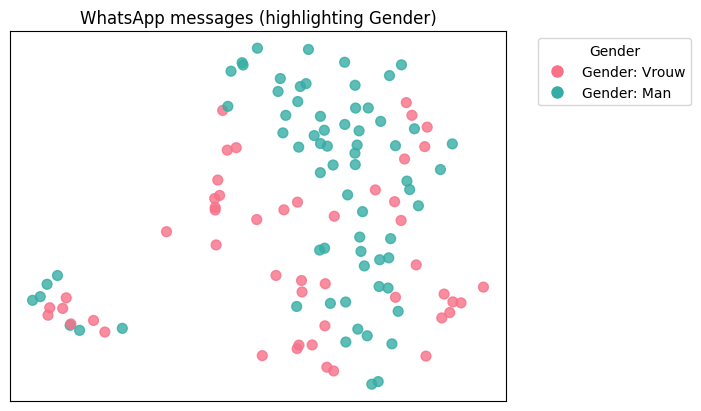

In [7]:
# %%
import seaborn as sns
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
import re
from sklearn.feature_extraction.text import CountVectorizer
from wa_analyzer.model import TextClustering

# Initialize clustering model
clustering = TextClustering()

# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# --- Load configuration and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

df = pd.read_parquet(datafile)

# %%
# --- Count messages per author ---
top_authors = df['author'].value_counts().head(40).index  # Increase to 40 for more variety
df_top = df[df['author'].isin(top_authors)].copy()
authors = list(np.unique(df_top.author))
print(f"Number of top authors: {len(authors)}")

# %%
# --- Helper to remove URLs ---
def remove_url(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

# %%
# --- Create corpus of text chunks per author ---
n = 3000       # chunk size
min_parts = 2  # minimum chunks

corpus = {}
for author in authors:
    subset = df_top[df_top.author == author].reset_index()
    longseq = " ".join(subset.message)
    parts = [longseq[i:i+n] for i in range(0, len(longseq), n)]
    parts = [remove_url(chunk) for chunk in parts]
    parts = [re.sub(" +", " ", chunk) for chunk in parts]
    if len(parts) > min_parts:
        corpus[author] = parts

print(f"\nFinal corpus authors: {list(corpus.keys())}")

# %%
# --- Feature extraction ---
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
parts = [part for text in corpus.values() for part in text]
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())
print(f"Feature matrix shape: {X.shape}")

# %%
# --- Load author metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
)

# %%
# --- Prepare labels for clustering based on Gender ---
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]
gender_map = author_info_df.set_index("author")["Gender"].to_dict()

# Encode labels and assign colors
colors = []
unique_genders = list(set(gender_map.values()))
gender_colors = sns.color_palette("husl", len(unique_genders))  # Generate distinct colors

for author in wa_labels:
    gender = gender_map.get(author, None)
    if gender is not None:
        gender_index = unique_genders.index(gender)
        colors.append(gender_colors[gender_index])  # Assign color based on gender
    else:
        colors.append("lightgrey")  # Default color for unknown genders

# %%
# --- Run clustering ---
clustering(
    text=[part for text in corpus.values() for part in text],
    k=500,
    labels=None,  # We'll handle coloring manually
    batch=False,
    method="tSNE"
)

# %%
# --- Overlay points with manual colors ---
# Extract the scatter points from the last clustering plot
sc = plt.gca().collections[0]
offsets = sc.get_offsets()

plt.clf()  # Clear previous plot
plt.scatter(offsets[:, 0], offsets[:, 1], c=colors, s=50, alpha=0.8)

# Legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Gender: {gender}')
    for gender, color in zip(unique_genders, gender_colors)
]
plt.legend(handles=legend_elements, title="Gender", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.xticks([])
plt.yticks([])
plt.title("WhatsApp messages (highlighting Gender)")

plt.show()

Number of top authors: 40

Final corpus authors: ['cackling-eland', 'carefree-lark', 'cheerful-mule', 'eye-catching-hare', 'flexible-platypus', 'happy-beaver', 'intense-toad', 'limber-ostrich', 'radiant-coyote', 'silky-lapwing', 'snorting-ibex', 'springy-hare', 'sudsy-eland', 'sudsy-jellyfish', 'vivid-rhinoceros', 'zany-trout']
Feature matrix shape: (118, 11016)


2025-10-18 12:54:14.989 | INFO     | wa_analyzer.model:fit:35 - Vectorized text into shape (118, 11016)
2025-10-18 12:54:15.174 | INFO     | wa_analyzer.model:reduce_dims:45 - Using t-SNE


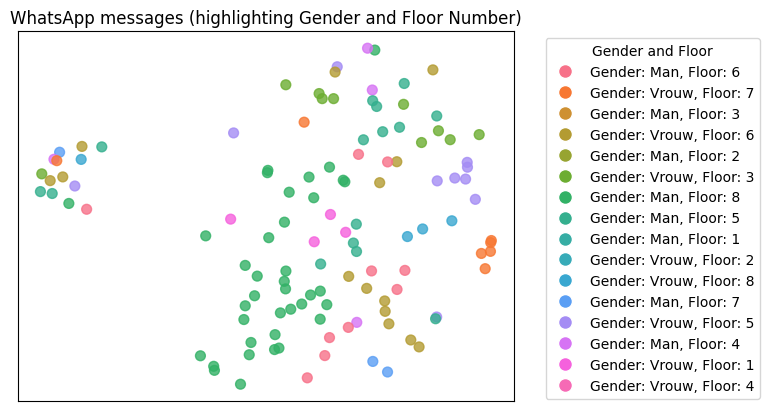

In [8]:
# %%
import seaborn as sns
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
import re
from sklearn.feature_extraction.text import CountVectorizer
from wa_analyzer.model import TextClustering

# Initialize clustering model
clustering = TextClustering()

# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# --- Load configuration and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

df = pd.read_parquet(datafile)

# %%
# --- Count messages per author ---
top_authors = df['author'].value_counts().head(40).index  # Increase to 40 for more variety
df_top = df[df['author'].isin(top_authors)].copy()
authors = list(np.unique(df_top.author))
print(f"Number of top authors: {len(authors)}")

# %%
# --- Helper to remove URLs ---
def remove_url(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

# %%
# --- Create corpus of text chunks per author ---
n = 3000       # chunk size
min_parts = 2  # minimum chunks

corpus = {}
for author in authors:
    subset = df_top[df_top.author == author].reset_index()
    longseq = " ".join(subset.message)
    parts = [longseq[i:i+n] for i in range(0, len(longseq), n)]
    parts = [remove_url(chunk) for chunk in parts]
    parts = [re.sub(" +", " ", chunk) for chunk in parts]
    if len(parts) > min_parts:
        corpus[author] = parts

print(f"\nFinal corpus authors: {list(corpus.keys())}")

# %%
# --- Feature extraction ---
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
parts = [part for text in corpus.values() for part in text]
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())
print(f"Feature matrix shape: {X.shape}")

# %%
# --- Load author metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
)

# %%
# --- Prepare labels for clustering based on Gender and Floor_nr ---
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]
gender_map = author_info_df.set_index("author")["Gender"].to_dict()
floor_map = author_info_df.set_index("author")["Floor_nr"].to_dict()

# Encode labels and assign colors
colors = []
unique_labels = list(set((gender, floor) for gender, floor in zip(gender_map.values(), floor_map.values())))
label_colors = sns.color_palette("husl", len(unique_labels))  # Generate distinct colors

# Create a dictionary for label mapping
label_dict = {label: idx for idx, label in enumerate(unique_labels)}

for author in wa_labels:
    gender = gender_map.get(author, None)
    floor = floor_map.get(author, None)
    if gender is not None and floor is not None:
        label_index = label_dict[(gender, floor)]
        colors.append(label_colors[label_index])  # Assign color based on combined labels
    else:
        colors.append("lightgrey")  # Default color for unknown labels

# %%
# --- Run clustering ---
clustering(
    text=[part for text in corpus.values() for part in text],
    k=500,
    labels=None,  # We'll handle coloring manually
    batch=False,
    method="tSNE"
)

# %%
# --- Overlay points with manual colors ---
# Extract the scatter points from the last clustering plot
sc = plt.gca().collections[0]
offsets = sc.get_offsets()

plt.clf()  # Clear previous plot
plt.scatter(offsets[:, 0], offsets[:, 1], c=colors, s=50, alpha=0.8)

# Legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Gender: {gender}, Floor: {floor}')
    for (gender, floor), color in zip(unique_labels, label_colors)
]
plt.legend(handles=legend_elements, title="Gender and Floor", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.xticks([])
plt.yticks([])
plt.title("WhatsApp messages (highlighting Gender and Floor Number)")

plt.show()

Number of top authors: 40

Final corpus authors: ['cackling-eland', 'carefree-lark', 'cheerful-mule', 'eye-catching-hare', 'flexible-platypus', 'happy-beaver', 'intense-toad', 'limber-ostrich', 'radiant-coyote', 'silky-lapwing', 'snorting-ibex', 'springy-hare', 'sudsy-eland', 'sudsy-jellyfish', 'vivid-rhinoceros', 'zany-trout']
Feature matrix shape: (118, 11016)


2025-10-18 12:58:01.256 | INFO     | wa_analyzer.model:fit:35 - Vectorized text into shape (118, 11016)
2025-10-18 12:58:01.440 | INFO     | wa_analyzer.model:reduce_dims:45 - Using t-SNE


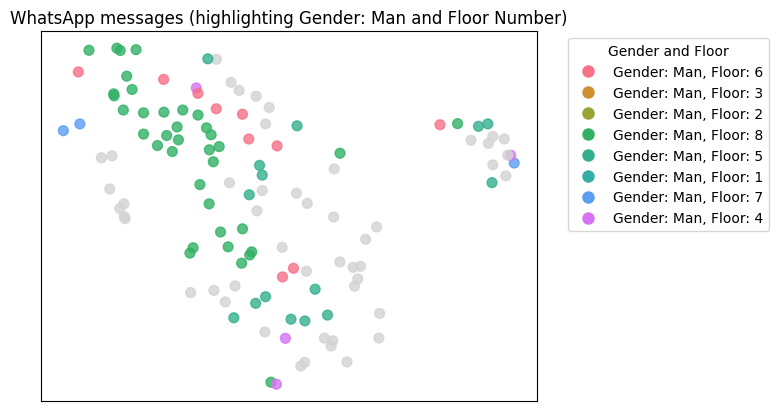

In [10]:
# %%
import seaborn as sns
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
import re
from sklearn.feature_extraction.text import CountVectorizer
from wa_analyzer.model import TextClustering

# Initialize clustering model
clustering = TextClustering()

# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# --- Load configuration and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

df = pd.read_parquet(datafile)

# %%
# --- Count messages per author ---
top_authors = df['author'].value_counts().head(40).index  # Increase to 40 for more variety
df_top = df[df['author'].isin(top_authors)].copy()
authors = list(np.unique(df_top.author))
print(f"Number of top authors: {len(authors)}")

# %%
# --- Helper to remove URLs ---
def remove_url(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

# %%
# --- Create corpus of text chunks per author ---
n = 3000       # chunk size
min_parts = 2  # minimum chunks

corpus = {}
for author in authors:
    subset = df_top[df_top.author == author].reset_index()
    longseq = " ".join(subset.message)
    parts = [longseq[i:i+n] for i in range(0, len(longseq), n)]
    parts = [remove_url(chunk) for chunk in parts]
    parts = [re.sub(" +", " ", chunk) for chunk in parts]
    if len(parts) > min_parts:
        corpus[author] = parts

print(f"\nFinal corpus authors: {list(corpus.keys())}")

# %%
# --- Feature extraction ---
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
parts = [part for text in corpus.values() for part in text]
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())
print(f"Feature matrix shape: {X.shape}")

# %%
# --- Load author metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
)

# %%
# --- Prepare labels for clustering based on Gender and Floor_nr ---
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]
gender_map = author_info_df.set_index("author")["Gender"].to_dict()
floor_map = author_info_df.set_index("author")["Floor_nr"].to_dict()

# Encode labels and assign colors
colors = []
unique_labels = list(set((gender, floor) for gender, floor in zip(gender_map.values(), floor_map.values())))
label_colors = sns.color_palette("husl", len(unique_labels))  # Generate distinct colors

# Create a dictionary for label mapping
label_dict = {label: idx for idx, label in enumerate(unique_labels)}

for author in wa_labels:
    gender = gender_map.get(author, None)
    floor = floor_map.get(author, None)
    if gender == "Man" and floor is not None:  # Only include Men
        label_index = label_dict[(gender, floor)]
        colors.append(label_colors[label_index])  # Assign color based on combined labels
    else:
        colors.append("lightgrey")  # Default color for unknown labels or women

# %%
# --- Run clustering ---
clustering(
    text=[part for text in corpus.values() for part in text],
    k=500,
    labels=None,  # We'll handle coloring manually
    batch=False,
    method="tSNE"
)

# %%
# --- Overlay points with manual colors ---
# Extract the scatter points from the last clustering plot
sc = plt.gca().collections[0]
offsets = sc.get_offsets()

plt.clf()  # Clear previous plot
plt.scatter(offsets[:, 0], offsets[:, 1], c=colors, s=50, alpha=0.8)

# Legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Gender: Man, Floor: {floor}')
    for (gender, floor), color in zip(unique_labels, label_colors) if gender == "Man"
]
plt.legend(handles=legend_elements, title="Gender and Floor", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.xticks([])
plt.yticks([])
plt.title("WhatsApp messages (highlighting Gender: Man and Floor Number)")

plt.show()

Number of top authors: 70

Final corpus authors: ['cackling-eland', 'carefree-lark', 'cheerful-mule', 'eye-catching-hare', 'flexible-platypus', 'happy-beaver', 'intense-toad', 'limber-ostrich', 'radiant-coyote', 'silky-lapwing', 'snorting-ibex', 'springy-hare', 'sudsy-eland', 'sudsy-jellyfish', 'vivid-rhinoceros', 'zany-trout']
Feature matrix shape: (118, 11016)


2025-10-18 13:02:27.898 | INFO     | wa_analyzer.model:fit:35 - Vectorized text into shape (118, 11016)
2025-10-18 13:02:28.120 | INFO     | wa_analyzer.model:reduce_dims:45 - Using t-SNE


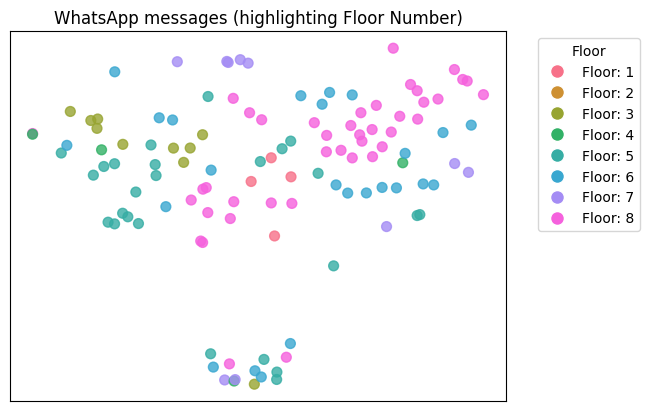

In [13]:
# %%
import seaborn as sns
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
import re
from sklearn.feature_extraction.text import CountVectorizer
from wa_analyzer.model import TextClustering

# Initialize clustering model
clustering = TextClustering()

# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# --- Load configuration and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

df = pd.read_parquet(datafile)

# %%
# --- Count messages per author ---
top_authors = df['author'].value_counts().head(70).index  # Increase to 40 for more variety
df_top = df[df['author'].isin(top_authors)].copy()
authors = list(np.unique(df_top.author))
print(f"Number of top authors: {len(authors)}")

# %%
# --- Helper to remove URLs ---
def remove_url(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

# %%
# --- Create corpus of text chunks per author ---
n = 3000       # chunk size
min_parts = 2  # minimum chunks

corpus = {}
for author in authors:
    subset = df_top[df_top.author == author].reset_index()
    longseq = " ".join(subset.message)
    parts = [longseq[i:i+n] for i in range(0, len(longseq), n)]
    parts = [remove_url(chunk) for chunk in parts]
    parts = [re.sub(" +", " ", chunk) for chunk in parts]
    if len(parts) > min_parts:
        corpus[author] = parts

print(f"\nFinal corpus authors: {list(corpus.keys())}")

# %%
# --- Feature extraction ---
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
parts = [part for text in corpus.values() for part in text]
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())
print(f"Feature matrix shape: {X.shape}")

# %%
# --- Load author metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
)

# %%
# --- Prepare labels for clustering based on Floor_nr ---
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]
floor_map = author_info_df.set_index("author")["Floor_nr"].to_dict()

# Encode labels and assign colors
colors = []
unique_floors = list(set(floor_map.values()))
floor_colors = sns.color_palette("husl", len(unique_floors))  # Generate distinct colors

for author in wa_labels:
    floor = floor_map.get(author, None)
    if floor is not None:  # Only include known floors
        floor_index = unique_floors.index(floor)
        colors.append(floor_colors[floor_index])  # Assign color based on floor
    else:
        colors.append("lightgrey")  # Default color for unknown floors

# %%
# --- Run clustering ---
clustering(
    text=[part for text in corpus.values() for part in text],
    k=500,
    labels=None,  # We'll handle coloring manually
    batch=False,
    method="tSNE"
)

# %%
# --- Overlay points with manual colors ---
# Extract the scatter points from the last clustering plot
sc = plt.gca().collections[0]
offsets = sc.get_offsets()

plt.clf()  # Clear previous plot
plt.scatter(offsets[:, 0], offsets[:, 1], c=colors, s=50, alpha=0.8)

# Legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Floor: {floor}')
    for floor, color in zip(unique_floors, floor_colors)
]
plt.legend(handles=legend_elements, title="Floor", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.xticks([])
plt.yticks([])
plt.title("WhatsApp messages (highlighting Floor Number)")

plt.show()


Number of top authors: 40

Final corpus authors: ['cackling-eland', 'carefree-lark', 'cheerful-mule', 'eye-catching-hare', 'flexible-platypus', 'happy-beaver', 'intense-toad', 'limber-ostrich', 'radiant-coyote', 'silky-lapwing', 'snorting-ibex', 'springy-hare', 'sudsy-eland', 'sudsy-jellyfish', 'vivid-rhinoceros', 'zany-trout']
Feature matrix shape: (118, 11016)


2025-10-18 13:07:19.214 | INFO     | wa_analyzer.model:fit:35 - Vectorized text into shape (118, 11016)
2025-10-18 13:07:19.412 | INFO     | wa_analyzer.model:reduce_dims:45 - Using t-SNE


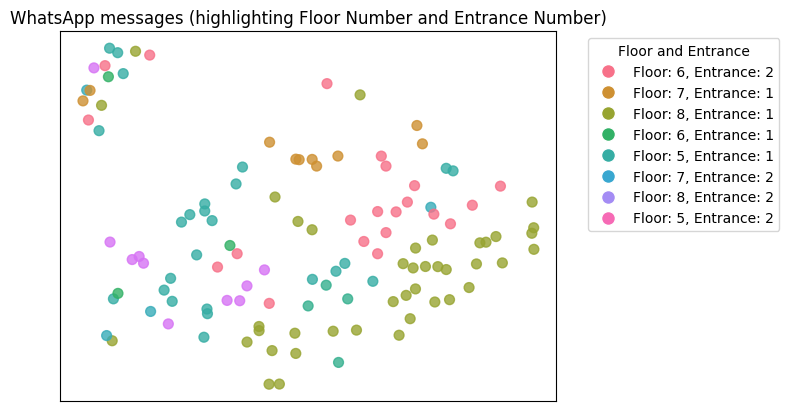

In [15]:
# %%
import seaborn as sns
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
import re
from sklearn.feature_extraction.text import CountVectorizer
from wa_analyzer.model import TextClustering

# Initialize clustering model
clustering = TextClustering()

# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# --- Load configuration and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

df = pd.read_parquet(datafile)

# %%
# --- Count messages per author ---
top_authors = df['author'].value_counts().head(40).index  # Increase to 40 for more variety
df_top = df[df['author'].isin(top_authors)].copy()
authors = list(np.unique(df_top.author))
print(f"Number of top authors: {len(authors)}")

# %%
# --- Helper to remove URLs ---
def remove_url(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

# %%
# --- Create corpus of text chunks per author ---
n = 3000       # chunk size
min_parts = 2  # minimum chunks

corpus = {}
for author in authors:
    subset = df_top[df_top.author == author].reset_index()
    longseq = " ".join(subset.message)
    parts = [longseq[i:i+n] for i in range(0, len(longseq), n)]
    parts = [remove_url(chunk) for chunk in parts]
    parts = [re.sub(" +", " ", chunk) for chunk in parts]
    if len(parts) > min_parts:
        corpus[author] = parts

print(f"\nFinal corpus authors: {list(corpus.keys())}")

# %%
# --- Feature extraction ---
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
parts = [part for text in corpus.values() for part in text]
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())
print(f"Feature matrix shape: {X.shape}")

# %%
# --- Load author metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
)

# %%
# --- Prepare labels for clustering based on Floor_nr and Entrance_nr ---
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]
floor_map = author_info_df.set_index("author")["Floor_nr"].to_dict()
entrance_map = author_info_df.set_index("author")["Entrance_nr"].to_dict()

# Encode labels and assign colors
colors = []
unique_labels = list(set((floor, entrance) for floor, entrance in zip(floor_map.values(), entrance_map.values())))
label_colors = sns.color_palette("husl", len(unique_labels))  # Generate distinct colors

for author in wa_labels:
    floor = floor_map.get(author, None)
    entrance = entrance_map.get(author, None)
    if floor is not None and entrance is not None:  # Only include known floors and entrances
        label_index = unique_labels.index((floor, entrance))
        colors.append(label_colors[label_index])  # Assign color based on floor and entrance
    else:
        colors.append("lightgrey")  # Default color for unknown floors or entrances

# %%
# --- Run clustering ---
clustering(
    text=[part for text in corpus.values() for part in text],
    k=500,
    labels=None,  # We'll handle coloring manually
    batch=False,
    method="tSNE"
)

# %%
# --- Overlay points with manual colors ---
# Extract the scatter points from the last clustering plot
sc = plt.gca().collections[0]
offsets = sc.get_offsets()

plt.clf()  # Clear previous plot
plt.scatter(offsets[:, 0], offsets[:, 1], c=colors, s=50, alpha=0.8)

# Legend
valid_floors = {5, 6, 7, 8}  # Set of floors to include in the legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Floor: {floor}, Entrance: {entrance}')
    for (floor, entrance), color in zip(unique_labels, label_colors)
    if floor in valid_floors  # Only include specified floors
]
plt.legend(handles=legend_elements, title="Floor and Entrance", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.xticks([])
plt.yticks([])
plt.title("WhatsApp messages (highlighting Floor Number and Entrance Number)")

plt.show()

Number of top authors: 40

Final corpus authors: ['cackling-eland', 'carefree-lark', 'cheerful-mule', 'eye-catching-hare', 'flexible-platypus', 'happy-beaver', 'intense-toad', 'limber-ostrich', 'radiant-coyote', 'silky-lapwing', 'snorting-ibex', 'springy-hare', 'sudsy-eland', 'sudsy-jellyfish', 'vivid-rhinoceros', 'zany-trout']
Feature matrix shape: (118, 11016)


2025-10-18 13:09:01.654 | INFO     | wa_analyzer.model:fit:35 - Vectorized text into shape (118, 11016)
2025-10-18 13:09:01.840 | INFO     | wa_analyzer.model:reduce_dims:45 - Using t-SNE


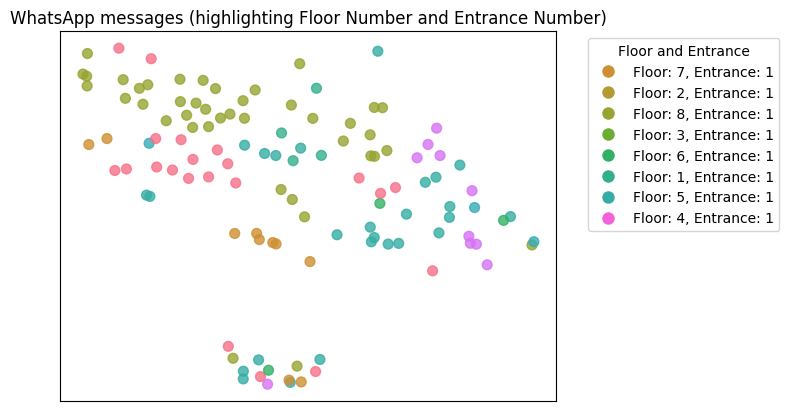

In [16]:
# %%
import seaborn as sns
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
import re
from sklearn.feature_extraction.text import CountVectorizer
from wa_analyzer.model import TextClustering

# Initialize clustering model
clustering = TextClustering()

# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# --- Load configuration and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

df = pd.read_parquet(datafile)

# %%
# --- Count messages per author ---
top_authors = df['author'].value_counts().head(40).index  # Increase to 40 for more variety
df_top = df[df['author'].isin(top_authors)].copy()
authors = list(np.unique(df_top.author))
print(f"Number of top authors: {len(authors)}")

# %%
# --- Helper to remove URLs ---
def remove_url(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

# %%
# --- Create corpus of text chunks per author ---
n = 3000       # chunk size
min_parts = 2  # minimum chunks

corpus = {}
for author in authors:
    subset = df_top[df_top.author == author].reset_index()
    longseq = " ".join(subset.message)
    parts = [longseq[i:i+n] for i in range(0, len(longseq), n)]
    parts = [remove_url(chunk) for chunk in parts]
    parts = [re.sub(" +", " ", chunk) for chunk in parts]
    if len(parts) > min_parts:
        corpus[author] = parts

print(f"\nFinal corpus authors: {list(corpus.keys())}")

# %%
# --- Feature extraction ---
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
parts = [part for text in corpus.values() for part in text]
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())
print(f"Feature matrix shape: {X.shape}")

# %%
# --- Load author metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
)

# %%
# --- Prepare labels for clustering based on Floor_nr and Entrance_nr ---
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]
floor_map = author_info_df.set_index("author")["Floor_nr"].to_dict()
entrance_map = author_info_df.set_index("author")["Entrance_nr"].to_dict()

# Encode labels and assign colors
colors = []
unique_labels = list(set((floor, entrance) for floor, entrance in zip(floor_map.values(), entrance_map.values())))
label_colors = sns.color_palette("husl", len(unique_labels))  # Generate distinct colors

for author in wa_labels:
    floor = floor_map.get(author, None)
    entrance = entrance_map.get(author, None)
    if floor is not None and entrance is not None:  # Only include known floors and entrances
        label_index = unique_labels.index((floor, entrance))
        colors.append(label_colors[label_index])  # Assign color based on floor and entrance
    else:
        colors.append("lightgrey")  # Default color for unknown floors or entrances

# %%
# --- Run clustering ---
clustering(
    text=[part for text in corpus.values() for part in text],
    k=500,
    labels=None,  # We'll handle coloring manually
    batch=False,
    method="tSNE"
)

# %%
# --- Overlay points with manual colors ---
# Extract the scatter points from the last clustering plot
sc = plt.gca().collections[0]
offsets = sc.get_offsets()

plt.clf()  # Clear previous plot
plt.scatter(offsets[:, 0], offsets[:, 1], c=colors, s=50, alpha=0.8)

# Legend
valid_entrance = 1  # Set the specific entrance to include in the legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Floor: {floor}, Entrance: {entrance}')
    for (floor, entrance), color in zip(unique_labels, label_colors)
    if entrance == valid_entrance  # Only include specified entrance
]
plt.legend(handles=legend_elements, title="Floor and Entrance", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.xticks([])
plt.yticks([])
plt.title("WhatsApp messages (highlighting Floor Number and Entrance Number)")

plt.show()

Number of top authors: 40

Final corpus authors: ['bold-bison', 'cackling-eland', 'carefree-lark', 'cheerful-mule', 'dazzling-yak', 'ebullient-mosquito', 'ethereal-lapwing', 'eye-catching-hare', 'flexible-platypus', 'goofy-tiger', 'happy-beaver', 'intense-toad', 'joyful-okapi', 'kooky-tapir', 'limber-ostrich', 'mind-blowing-kudu', 'peppy-rat', 'piebald-rhinoceros', 'quick-chamois', 'radiant-coyote', 'rollicking-ostrich', 'saturated-whistling duck', 'silky-lapwing', 'snorting-ibex', 'soft-eland', 'springy-hare', 'sudsy-eland', 'sudsy-jellyfish', 'sunny-gazelle', 'vivid-rhinoceros', 'waggish-porcupine', 'zany-trout']
Feature matrix shape: (796, 12234)


2025-10-18 12:48:57.634 | INFO     | wa_analyzer.model:fit:35 - Vectorized text into shape (796, 12234)
2025-10-18 12:49:06.460 | INFO     | wa_analyzer.model:reduce_dims:42 - Using PCA


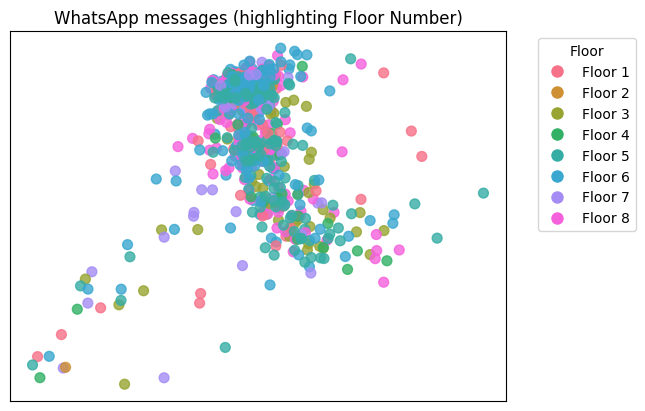

In [6]:
# %%
import seaborn as sns
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
import re
from sklearn.feature_extraction.text import CountVectorizer
from wa_analyzer.model import TextClustering

# Initialize clustering model
clustering = TextClustering()

# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# --- Load configuration and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

df = pd.read_parquet(datafile)

# %%
# --- Count messages per author ---
top_authors = df['author'].value_counts().head(40).index  # Increase to 40 for more variety
df_top = df[df['author'].isin(top_authors)].copy()
authors = list(np.unique(df_top.author))
print(f"Number of top authors: {len(authors)}")

# %%
# --- Helper to remove URLs ---
def remove_url(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

# %%
# --- Create corpus of text chunks per author ---
n = 500       # chunk size
min_parts = 4  # minimum chunks

corpus = {}
for author in authors:
    subset = df_top[df_top.author == author].reset_index()
    longseq = " ".join(subset.message)
    parts = [longseq[i:i+n] for i in range(0, len(longseq), n)]
    parts = [remove_url(chunk) for chunk in parts]
    parts = [re.sub(" +", " ", chunk) for chunk in parts]
    if len(parts) > min_parts:
        corpus[author] = parts

print(f"\nFinal corpus authors: {list(corpus.keys())}")

# %%
# --- Feature extraction ---
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
parts = [part for text in corpus.values() for part in text]
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())
print(f"Feature matrix shape: {X.shape}")

# %%
# --- Load author metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
)

# %%
# --- Prepare labels for clustering based on Floor_nr ---
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]
floor_map = author_info_df.set_index("author")["Floor_nr"].to_dict()

# Encode labels and assign colors
colors = []
unique_floors = list(set(floor_map.values()))
floor_colors = sns.color_palette("husl", len(unique_floors))  # Generate distinct colors

for author in wa_labels:
    floor = floor_map.get(author, None)
    if floor is not None:
        floor_index = unique_floors.index(floor)
        colors.append(floor_colors[floor_index])  # Assign color based on floor
    else:
        colors.append("lightgrey")  # Default color for unknown floors

# %%
# --- Run clustering ---
clustering(
    text=[part for text in corpus.values() for part in text],
    k=500,
    labels=None,  # We'll handle coloring manually
    batch=False,
    method="PCA" #"tSNE"
)

# %%
# --- Overlay points with manual colors ---
# Extract the scatter points from the last clustering plot
sc = plt.gca().collections[0]
offsets = sc.get_offsets()

plt.clf()  # Clear previous plot
plt.scatter(offsets[:, 0], offsets[:, 1], c=colors, s=50, alpha=0.8)

# Legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Floor {floor}')
    for floor, color in zip(unique_floors, floor_colors)
]
plt.legend(handles=legend_elements, title="Floor", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.xticks([])
plt.yticks([])
plt.title("WhatsApp messages (highlighting Floor Number)")

plt.show()